# Processing workflow example

In [29]:
%load_ext autoreload
%autoreload 2
from rime.process_config import *
from rime.rime_functions import *
from rime.utils import *
from rime.core import GMTPathway
from rime.core import RasterArray
from rime.core import RegionArray



import dask
import dask.dataframe as dd
# from dask.diagnostics import ProgressBar
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar
from dask.distributed import Client

# from dask.distributed import Client # uncomment this to open Dask client to see performance
import glob
import numpy as np
import pandas as pd
import pyam
import re
import time
import xarray as xr
import yaml

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Load a yaml file that will help select multiple climate indicator files (not necessarily needed)
with open("indicator_params.yml", "r") as f:
    params = yaml.full_load(f)

In [3]:
dask.config.set(scheduler="processes")
dask.config.set(num_workers=num_workers)
client = Client()  # uncomment this to open Dask client

To see the Dask dasboard, open http://localhost:8787/status in your browser

### Import scenarios data

Load an IAMC scenarios dataset.  We can use the one that comes with the package.
Filter for IPCC IMP and core IMAGE SSP scenarios.
Assign SSPs if missing and fix duplicate temperatures.  

In [4]:
df_scens_in = pyam.IamDataFrame('test_data/emissions_temp_AR6_small.xlsx')
scenarios = ["SSP1-26", "SSP2-45", "SSP3-Baseline", "SSP5-Baseline"]
variable = (
    "AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile"
)
ssps = df_scens_in.filter(scenario=scenarios, model="IMAGE*")#, variable=variable)
imps = df_scens_in.filter(
    IMP_marker=["CurPol", "ModAct", "SP", "GS", "Neg"])#, variable=variable)  # ,'Ren-2.0','Neg-2.0'
ssps_imp = ssps.append(imps)
# ssps_imp = ssp_helper(ssps_imp, ssp_meta_col="Ssp_family", default_ssp="SSP2")
ssps_imp = GMTPathway(ssps_imp, temperature_variable=variable)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file test_data/emissions_temp_AR6_small.xlsx
/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/utils.py:347: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df.set_index(index + REQUIRED_COLS + extra_cols)
/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)
pyam.core - INFO: Reading meta indicators


AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile
Temperature_variable(s) provided: AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile


/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)
/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)
/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)
/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = p

# Generate some maps

## Example 1: multiple IAM scenarios, 1 climate indicator

In [44]:
# Requires some configuration -
# Either use the existing test data in the repo or download the full data from https://zenodo.org/records/10212339, and set the file paths in the file process_config.py

In [9]:
# load data from test data within repo

ssp = "ssp2"
ftype = "abs"
impact_data_dir = 'test_data'  # test data in the repo
ind = 'dri_qtot'
files = glob.glob(f"{impact_data_dir}/*{ind}_*{ftype}.nc4")

mapdata = RasterArray(files)
mapdata

FrozenMappingWarningOnValuesAccess({'lon': 720, 'lat': 360, 'gwl': 5})


/home/byers/rime/rime/core.py:114: UserWarning: rename 'threshold' to 'gwl' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.dataset = self.dataset.rename({"threshold": "gwl"}) if "threshold" in self.dataset.coords else self.dataset


<xarray.Dataset> Size: 10MB
Dimensions:   (lon: 720, lat: 360, gwl: 5)
Coordinates:
  * lon       (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat       (lat) float32 1kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * gwl       (gwl) float64 40B 1.2 1.5 2.0 2.5 3.0
Data variables:
    dri_qtot  (gwl, lat, lon) float64 10MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>

In [ ]:
# Prepare data (using split_files on sharepoint)
# impact_data_dir = '/mnt/c/users/byers/iiasa/ECE.prog - Documents/Research Theme - NEXUS/Hotspots_Explorer_2p0/rcre_testing/rime_testdata'
# impact_data_dir = 'test_data'
# # indicators = ['dri','iavar']
# ind = 'dri_qtot'

# files = glob.glob(f"{impact_data_dir}/*{ind}_*{ftype}.nc4")
# mapdata = xr.open_mfdataset(
#     files, preprocess=remove_ssp_from_ds, combine="nested", concat_dim="gwl"
# )

# mapdata.data

In [11]:
print("Test multiple IAM scenarios, 1 indicator")

start = time.time()

# Run function
# Using dask for small numbers of scenarios ~<10 can be slower due to spawning of workers.
# use_dask=True works, but unintended behavious, only produces data for 1 IAM scenario, not all. Check aggregation
map_out_MS = map_transform_gwl_wrapper(
    ssps_imp,
    mapdata,
    years,
    caution_checks=True,
    use_dask=False,
    include_orig_gwl=False,
    gwl_name="gwl",
    drawdown_max=0.15,
    temp_min=1.2,
    temp_max=3.0,
    interpolation=0.01,
)

comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in map_out_MS.data_vars}
filename = f"scenario_maps_multiscenario_{ftype}_test_notebook.nc"
map_out_MS.to_netcdf(filename, encoding=encoding)

print("FINISHED Test multiple scenarios, 1 indicator")
print(f"{time.time()-start}")

Test multiple IAM scenarios, 1 indicator
Single indicator mode (multi-scenarios possible)
COFFEE_1_1_EN_NPi2020_400f_lowBECCS
GCAM_5_3_NGFS2_Current Policies
IMAGE_3_0_EN_INDCi2030_3000f
IMAGE_3_0_1_SSP1-26
IMAGE_3_0_1_SSP2-45
IMAGE_3_0_1_SSP3-Baseline
IMAGE_3_0_1_SSP5-Baseline
REMIND-MAgPIE_2_1-4_2_SusDev_SDP-PkBudg1000
WITCH_5_0_CO_Bridge


/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)
/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)
/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)
/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = p

FINISHED Test multiple scenarios, 1 indicator
7.238605499267578


In [ ]:
map_out_MS.COFFEE_1_1_EN_NPi2020_400f_lowBECCS.sel(year=2050).plot()

## Example 2: ONE scenario, multiple climate indicators


### Build combined dataset with multiple indicators

In [14]:
# Doesn't work -0
# AttributeError: 'DataArray' object has no attribute 'rename_vars'
# lines 230-233 in map_transform_gmt

gwl_name = "gwl"
print("Test 1 scenario, multiple climate indicators")
ssp = "ssp2"
mapdata = xr.Dataset()

# impact_data_dir = '/mnt/p/watxene/ISIMIP_postprocessed/cse/split_files_fixed'
impact_data_dir = 'test_data'
indicators = ['dri','iavar']
for ind in indicators:

    print(ind)
    files = glob.glob(f"{impact_data_dir}/ISI*{ind}*_{ftype}*.nc4")
        
    # a = xr.open_mfdataset(
            # files, preprocess=remove_ssp_from_ds, combine="nested", concat_dim="gwl")

    a = RasterArray(files)
    
    for x in a.xrdataset.data_vars:
        mapdata[x] = a.xrdataset[x]

mapdata = RasterArray(mapdata)
mapdata

Test 1 scenario, multiple climate indicators
dri
FrozenMappingWarningOnValuesAccess({'lon': 720, 'lat': 360, 'gwl': 5})
iavar
FrozenMappingWarningOnValuesAccess({'lon': 720, 'lat': 360, 'gwl': 5})
FrozenMappingWarningOnValuesAccess({'lon': 720, 'lat': 360, 'gwl': 5})


/home/byers/rime/rime/core.py:114: UserWarning: rename 'threshold' to 'gwl' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.dataset = self.dataset.rename({"threshold": "gwl"}) if "threshold" in self.dataset.coords else self.dataset
/home/byers/rime/rime/core.py:114: UserWarning: rename 'threshold' to 'gwl' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  self.dataset = self.dataset.rename({"threshold": "gwl"}) if "threshold" in self.dataset.coords else self.dataset


<xarray.Dataset> Size: 16MB
Dimensions:     (lon: 720, lat: 360, gwl: 5)
Coordinates:
  * lon         (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat         (lat) float32 1kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * gwl         (gwl) float64 40B 1.2 1.5 2.0 2.5 3.0
Data variables:
    dri_qtot    (gwl, lat, lon) float64 10MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    iavar_qtot  (gwl, lat, lon) float32 5MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>

### Run transformation (2 impact indicators) (faster with dask=False)

In [15]:
# Notes - works with use_dask=False
# True gives problem that DataArray is being passed to map_transform_gwl instead of DS
# Approx error L279. mapdata_interp should be a DS
# Possibly its empty, cannot convert to 
# AttributeError: 'DataArray' object has no attribute 'data_vars'


start = time.time()
map_out_MI = map_transform_gwl_wrapper(
    ssps_imp.df.filter(IMP_marker="CurPol"),
    mapdata,
    years,
    use_dask=False,
    include_orig_gwl=False,
    gwl_name="gwl",
    drawdown_max=0.15,
    temp_min=1.2,
    temp_max=3.0,
    interpolation=0.01,
)

comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in map_out_MI.data_vars}
filename = f"scenario_maps_multiindicator_{ftype}_test_notebook.nc"
map_out_MI.to_netcdf(filename, encoding=encoding)

print("FINISHED 1 scenario, multiple indicators")
print(f"{time.time()-start}")

/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)
/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)
/home/byers/rime/rime/rime_functions.py:317: UserWarning: rename 'gwl' to 'year' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  updated_data = updated_data.rename({"gwl":"year"})


Single scenario mode, multiple indicators possible
Warning! Max temperature above 3.0°C  3.05, data thereafter not possible
Warning! Min temperature below 1.2°C  1.12, data before not possible
Warning! Provided scenario temperatures are higher than the available climate impacts GWLs. Setting temp_max to 3.0
Warning! Provided scenario temperatures are lower than the available climate impacts GWLs. Setting temp_min to 1.2
FINISHED 1 scenario, multiple indicators
1.7668366432189941


### Data is now transformed to 5 year interval starting 2015

In [16]:
map_out_MI

<xarray.Dataset> Size: 75MB
Dimensions:     (lat: 360, lon: 720, year: 18)
Coordinates:
  * lon         (lon) float32 3kB -179.8 -179.2 -178.8 ... 178.8 179.2 179.8
  * lat         (lat) float32 1kB 89.75 89.25 88.75 ... -88.75 -89.25 -89.75
  * year        (year) int64 144B 2015 2020 2025 2030 ... 2085 2090 2095 2100
Data variables:
    dri_qtot    (lat, lon, year) float64 37MB dask.array<chunksize=(360, 720, 1), meta=np.ndarray>
    iavar_qtot  (lat, lon, year) float64 37MB dask.array<chunksize=(360, 720, 1), meta=np.ndarray>
Attributes:
    model:     GCAM 5.3
    scenario:  NGFS2_Current Policies

## Plot dashboard (takes some minutes)

In [18]:
filename = "test_map_notebook.html"
plot_maps_dashboard(
    map_out_MI,
    filename=filename,
    year=2063,
    cmap="magma_r",
    shared_axes=True,
    clim=None,
)

from sys import platform
if platform == "linux" or platform == "linux2":
    # linux
    import webbrowser
    webbrowser.open(f'file://{os.path.realpath(filename)}')
# elif platform == "darwin":
    # OS X
elif platform == "win32":
    # Windows...
    os.startfile(filename) # Windows


## Process corresponding table data, aggregated by country or R10 region

### Select scenarios data
Load an IAMC scenarios dataset (done previously at the beginning).  
Decide whether using global mean temperature or CO2 mode.  
Assign SSPs if missing and fix duplicate temperatures. 

### Import the climate impacts database files
Here is an example for sdii - standard precipitation index, and multiple variables, e.g.  
Exposure of land area  
Exposure of population  
Hazard value  
...  


In [45]:
# input_table_impacts_dir = '/home/byers/Sharepoint/ECE.prog - Documents/Research Theme - NEXUS/Hotspots_Explorer_2p0/rcre_testing/testing_3/aggregated_region_datafiles/'
input_table_impacts_dir = 'test_data'
region_choice = 'R10'
filesall = glob.glob(f'{input_table_impacts_dir}/*{region_choice}.nc')
files = filesall  # [:6]

# load input climate impacts data file
ds = xr.open_mfdataset(files)
ds = RegionArray(files)
ds

<xarray.Dataset> Size: 230MB
Dimensions:                                       (gwl: 251, year: 91, ssp: 3,
                                                   region: 10)
Coordinates:
  * gwl                                           (gwl) float64 2kB 1.2 ... 3.5
  * year                                          (year) int64 728B 2010 ... ...
  * ssp                                           (ssp) <U4 48B 'SSP1' ... 'S...
  * region                                        (region) <U83 3kB 'Countrie...
Data variables: (12/42)
    cdd|Exposure|Land area                        (gwl, year, ssp, region) float64 5MB dask.array<chunksize=(251, 91, 3, 10), meta=np.ndarray>
    cdd|Exposure|Land area|%                      (gwl, year, ssp, region) float64 5MB dask.array<chunksize=(251, 91, 3, 10), meta=np.ndarray>
    cdd|Exposure|Land area|High                   (gwl, year, ssp, region) float64 5MB dask.array<chunksize=(251, 91, 3, 10), meta=np.ndarray>
    cdd|Exposure|Land area|High|%       

In [54]:
lvaris = 00
if lvaris>1:
    varis = list(ds.dataset.data_vars.keys())[:lvaris]
    dsi = ds[varis]
else:
    dsi = ds    
print(f"# of variables = {len(dsi.dataset.data_vars.keys())}")

# of variables = 42


### Select scenarios data
Load an IAMC scenarios dataset (done previously at the beginning).  
Decide whether using global mean temperature or CO2 mode.  
Assign SSPs if missing and fix duplicate temperatures. 

In [60]:
# Choose size of scenario set, comment out as appropriate.

# 1. Computational test - lots of scenarios (~1200)
# dfp = df_scens_in.filter(variable=temp_variable)
# dfp = dfp.filter(year=years)
# dfp = GMTPathway(dfp, temperature_variable=temp_variable)


# 2. For testing on C1 scenarios (97)
# few_scenarios = True
# very_few_scenarios = False

# if few_scenarios:
#     dfp = dfp.df.filter(Category=["C1*"])
#     if very_few_scenarios:
#         dfp = dfp.df.filter(model="REMIND 2.1*", scenario="*")

# 3. Use the small set as loaded at the start
dfp = ssps_imp

dfp

<class 'pyam.core.IamDataFrame'>
Index:
 * model    : COFFEE 1.1, GCAM 5.3, IMAGE 3.0, IMAGE 3.0.1, ... WITCH 5.0 (6)
 * scenario : CO_Bridge, EN_INDCi2030_3000f, ... SusDev_SDP-PkBudg1000 (9)
Timeseries data coordinates:
   region   : World (1)
   variable : ... (1)
   unit     : K (1)
   year     : 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, ... 2100 (86)
Meta indicators:
   Category (object) C3, C7, C6, C8, C1 (5)
   Category_name (object) C3: limit warming to 2°C (>67%), ... (5)
   Category_subset (object) C3x_NZGHGs, C7, C6, C8, C1a_NZGHGs (5)
   Subset_Ch4 (object) Limit to 2C (>67%) immediate 2020 action, ... (3)
   Category_Vetting_historical (object) C3, C7, C6, C8, C1 (5)
   ...

In [61]:
# pre-prepare the dataset into correct format - IAMC wide timeseries format

dft = dfp.df.timeseries()
dft = dft.join(dfp.meta["Ssp_family"]).reset_index()
# dft = dft.apply(fix_duplicate_temps, years=years, axis=1)

### START PROCESSING 

In [64]:
start = time.time()
year_res = 5
parallel = True
if parallel:
    """
    For parallel processing, convert dft as a wide IAMC pd.Dataframe
    into a dask.DataFrame.
    """
    ddf = dd.from_pandas(dft, npartitions=1000)

    # dfx = dft.iloc[0].squeeze()  # FOR DEBUIGGING THE FUNCTION
    outd = ddf.apply(
        table_impacts_gwl,
        dsi=dsi,
        ssp_meta_col="Ssp_family",
        axis=1,
        meta=("result", None),
    )

    with ProgressBar():
        # try:
        df_new = outd.compute(num_workers=num_workers)
else:
    df_new = dft.apply(table_impacts_gwl, dsi=dsi, axis=1)

expandeddGWL = pd.concat([df_new[x] for x in df_new.index])
print(f" Done:  {time.time()-start}")

filename = f"RIME_output_{region}_{year_res}yr.csv"

# expandedd.to_csv(filename, encoding="utf-8", index=False)
print(f" Saved: {region} yrs={year_res}\n  {time.time()-start}")
print(f"{len(dsi.dataset.data_vars)} variables, {len(dfp.meta)} scenarios")

/home/byers/rime/rime/rime_functions.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, edf]).reset_index(drop=True)
/home/byers/rime/rime/rime_functions.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  idf = pd.concat([idf, edf]).reset_index(drop=True)
/home/byers/rime/rime/rime_functions.py:159: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns

 Done:  6.4104859828948975
 Saved: COUNTRIES yrs=5
  6.4106457233428955
42 variables, 9 scenarios


To see the Dask dasboard, open http://localhost:8787/status in your browser

In [65]:
expandeddGWL = pyam.IamDataFrame(expandeddGWL)

/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/utils.py:347: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df.set_index(index + REQUIRED_COLS + extra_cols)
/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)


In [72]:
expandeddGWL.variable

['RIME|cdd|Exposure|Land area',
 'RIME|cdd|Exposure|Land area|%',
 'RIME|cdd|Exposure|Land area|High',
 'RIME|cdd|Exposure|Land area|High|%',
 'RIME|cdd|Exposure|Land area|Low',
 'RIME|cdd|Exposure|Land area|Low|%',
 'RIME|cdd|Exposure|Population',
 'RIME|cdd|Exposure|Population|%',
 'RIME|cdd|Exposure|Population|High',
 'RIME|cdd|Exposure|Population|High|%',
 'RIME|cdd|Exposure|Population|Low',
 'RIME|cdd|Exposure|Population|Low|%',
 'RIME|cdd|Hazard|Absolute',
 'RIME|cdd|Hazard|Absolute|Land area weighted',
 'RIME|cdd|Hazard|Absolute|Population weighted',
 'RIME|cdd|Hazard|Difference',
 'RIME|cdd|Hazard|Difference|Land area weighted',
 'RIME|cdd|Hazard|Difference|Population weighted',
 'RIME|cdd|Hazard|Risk score',
 'RIME|cdd|Hazard|Risk score|Land area weighted',
 'RIME|cdd|Hazard|Risk score|Population weighted',
 'RIME|pr_r10|Exposure|Land area',
 'RIME|pr_r10|Exposure|Land area|%',
 'RIME|pr_r10|Exposure|Land area|High',
 'RIME|pr_r10|Exposure|Land area|High|%',
 'RIME|pr_r10|Expo

/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)


<Axes: title={'center': 'region: Countries of South Asia; primarily India - variable: RIME|pr_r10|Exposure|Population|%'}, xlabel='Year', ylabel='%'>

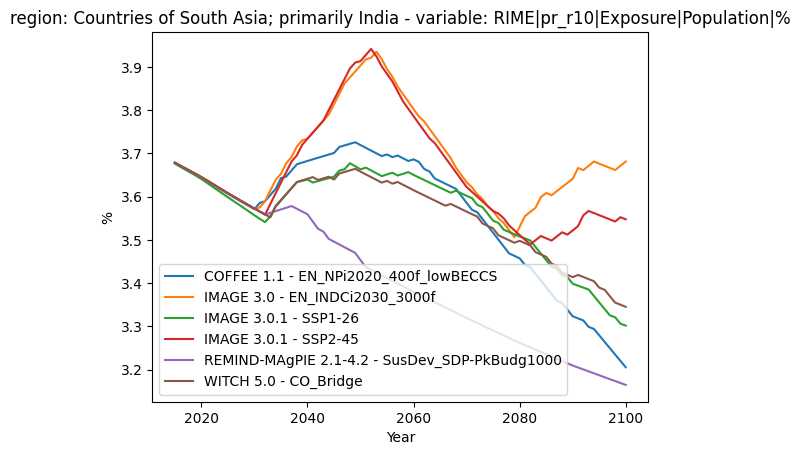

In [73]:
# model = "IMAG*"
scenario = [
    "CO_Bridge",
    "EN_INDCi2030_3000f",
    "EN_NPi2020_400f_lowBECCS",
    # 'NGFS2_Current Policies',
    "SSP1-26",
    "SSP2-45",
    # 'SSP3-Baseline',
    # 'SSP5-Baseline',
    "SusDev_SDP-PkBudg1000",
]
variable = "RIME|cdd|Hazard|Risk score|Population weighted"
# variable = 'RIME|wsi|Exposure|Population|%'
variable = "RIME|pr_r10|Exposure|Population|%"
expandeddGWL.filter(variable=variable, scenario=scenario, region="Countries of South Asia; primarily India").plot()

### Make SSP & IMP plots for presentation

In [74]:
imps.scenario

['EN_NPi2020_400f_lowBECCS',
 'NGFS2_Current Policies',
 'EN_INDCi2030_3000f',
 'SusDev_SDP-PkBudg1000',
 'CO_Bridge']

/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)


<Axes: xlabel='Year', ylabel='K'>

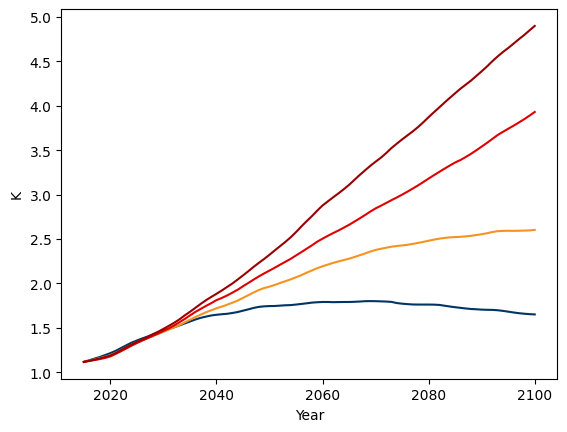

In [76]:
color_map = {
    "SSP1-26": "AR6-SSP1-2.6",
    "SSP2-45": "AR6-SSP2-4.5",
    "SSP3-Baseline": "AR6-SSP3-7.0",
    "SSP5-Baseline": "AR6-SSP5-8.5",
    "NGFS2_Current Policies": "AR6-IP-CurPol",
    # 'EN_NPi2020_900f': 'AR6-IMP-Neg2.0',
    "EN_INDCi2030_3000f": "AR6-IP-ModAct",
    # 'SSP2_openres_lc_50': 'AR6-IMP-Ren2.0',
    # AR6-IMP-GS',
    "CO_Bridge": "AR6-IMP-GS",
    "EN_NPi2020_400f_lowBECCS": "AR6-IMP-Neg",
    "SusDev_SDP-PkBudg1000": "AR6-IMP-SP",
}

pyam.run_control().update({"color": {"scenario": color_map}})

ssps_imp.df.filter(
    variable="AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile",
    scenario="SSP*",
).plot(legend=False, fill_between=True, color="scenario", title="")

/home/byers/venvs/rimeclasses/lib/python3.10/site-packages/pyam/core.py:2691: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  index = pd.unique(index)


<Axes: xlabel='Year', ylabel='K'>

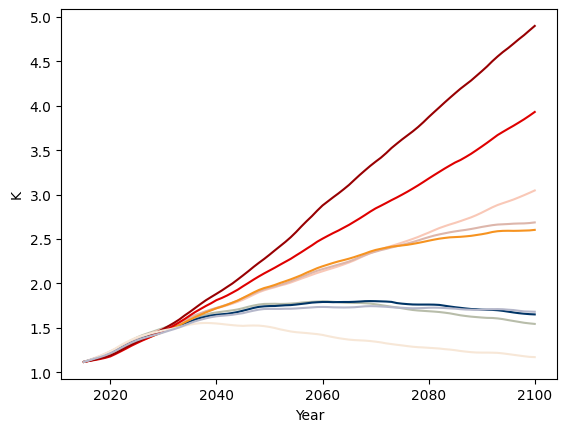

In [77]:
ssps_imp.df.filter(
    variable="AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile"
).plot(legend=False, fill_between=True, color="scenario", title="")